In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy


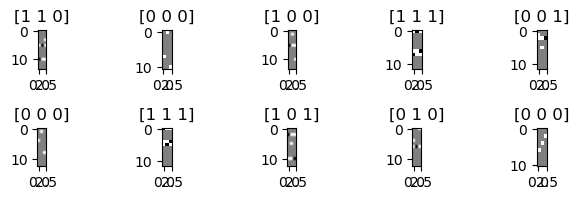

In [109]:
def generateTrainData(samples,noise,delayRange,baseTPS=[0,1,2,3,4],conceptNoise=[0.0,0.0,0.0]):
    sequences=[]
    targets=[]
    for s in range(samples):
        S=[]
        tps=numpy.random.choice(baseTPS,(3),replace=False)
        concept=numpy.random.choice([0,1],(3))
        seq=numpy.zeros((len(baseTPS)+numpy.random.choice(delayRange),3))+0.5
        for i,tp in enumerate(tps):
            if numpy.random.random()<conceptNoise[i]:
                V=seq[tp]
            else:
                if concept[i]==0:
                    V=numpy.zeros((3))+0.5
                    V[i]=1.0
                if concept[i]==1:
                    V=numpy.ones((3))+0.5
                    V[i]=0.0
            seq[tp]=V
        seq+=numpy.random.normal(0.0,noise,seq.shape)
        seq[numpy.where(seq<0.0)]=0.0
        seq[numpy.where(seq>1.0)]=1.0
        sequences.append(seq)
        targets.append(concept)
    return sequences,numpy.array(targets)

s,t=generateTrainData(10,0.0,[1,2,3,4,5],baseTPS=[0,1,2,3,4,5,6,7,8,10])
for i in range(len(s)):
    subplot(5,5,i+1)
    imshow(s[i],cmap='gray',vmin=0.0,vmax=1.0)
    title(str(t[i]))
tight_layout()

In [125]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12,inp=3):
        super(NetRNN, self).__init__()
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 3)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp=inp
        
    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                #print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                #print(out.detach().numpy().flatten().shape)
        return numpy.array(O),numpy.array(H)


model = NetRNN()

In [89]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12,inp=3):
        super(NetGRU, self).__init__()
        self.gruLayer = nn.GRU(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 3)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp=inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        #print(self.h0.shape)
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.gruLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                #print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                #print(out.detach().numpy().flatten().shape)
        return numpy.array(O),numpy.array(H)
    
    

    
model=NetGRU(hidden_dim=12)

In [90]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12,inp=3):
        super(NetLSTM, self).__init__()
        self.lstmLayer = nn.LSTM(inp, int(hidden_dim/2), 1,batch_first=True)
        self.outputLayer = nn.Linear(int(hidden_dim/2), 3)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp=inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)
        hh=numpy.concatenate((self.h0[0].detach().numpy(),self.h0[1].detach().numpy()),2)
        self.hidden.append(hh)
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.Tensor(numpy.zeros((1, 1, int(self.hidden_dim/2)))),
                  torch.Tensor(numpy.zeros((1, 1, int(self.hidden_dim/2)))))
            for i in range(x.shape[1]):
                out, h0 = self.lstmLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                hh=numpy.concatenate((h0[0].detach().numpy().flatten(),h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())
                #print(hh.flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                #print(out.detach().numpy().flatten().shape)
        return numpy.array(O),numpy.array(H)
    
    

    
model=NetLSTM(hidden_dim=12)


In [91]:
s,t=generateTrainData(100,0.1,[5])
output=model(torch.Tensor(s))
print(output.shape)
print(model)

torch.Size([100, 3])
NetLSTM(
  (lstmLayer): LSTM(3, 6, batch_first=True)
  (outputLayer): Linear(in_features=6, out_features=3, bias=True)
)


In [331]:
numpy.round([0,0.5,1.0],1)

array([0. , 0.5, 1. ])

In [108]:
collectorA=dict()
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    #if cond>3:
    if True:
        for rep in range(20):
            for kind in ["RNN","GRU","LSTM"]:
                if kind=="RNN":
                    model=NetRNN(hidden_dim=12)
                if kind=="GRU":
                    model=NetGRU(hidden_dim=12)
                if kind=="LSTM":
                    model=NetLSTM(hidden_dim=12)

                optimizer = optim.Adam(model.parameters())
                error = nn.MSELoss()

                acc=0.0
                W=[]
                A=[]
                while acc<0.97:
                    model.resetHidden()
                    s,t=generateTrainData(100,0.05,td,baseTPS=[0,1,2,3,4,5,6,7,8,9])
                    divs=[]
                    for i in range(s.shape[0]): #use 64 when training for single delayRange
                        optimizer.zero_grad()
                        output = model(torch.Tensor(s[i].reshape(1,s[i].shape[0],3))) #shape greater than 8
                        loss = error(output, torch.Tensor(t[i]))
                        loss.backward()
                        optimizer.step()
                        div=output.detach().numpy().reshape(t[i].shape)-t[i]
                        divs.append(1.0-abs(div).mean())
                    W.append(loss.item())
                    acc=mean(divs)
                    A.append(acc)
                    #print(len(W),acc)
                    if acc<0.97 and len(A)>2000:
                        if kind=="RNN":
                            model=NetRNN(hidden_dim=12)
                        if kind=="GRU":
                            model=NetGRU(hidden_dim=12)
                        if kind=="LSTM":
                            model=NetLSTM(hidden_dim=12)
                        optimizer = optim.Adam(model.parameters())
                        error = nn.MSELoss()
                        acc=0.0
                        W=[]
                        A=[]
                        print('repeat')
                #collectorA["{0} {1} {2}".format(kind,cond,rep)]=A
                #torch.save(model,"modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
                print("{0} {1} {2}".format(kind,cond,rep),len(A))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

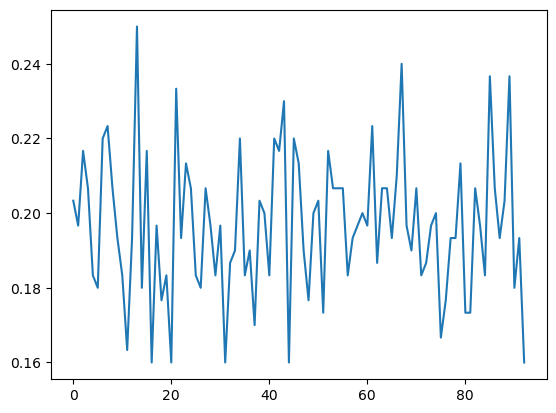

In [325]:
plot(A)

In [251]:
pickle.dump(collectorA,open("collectorALongDelay.p","bw"))


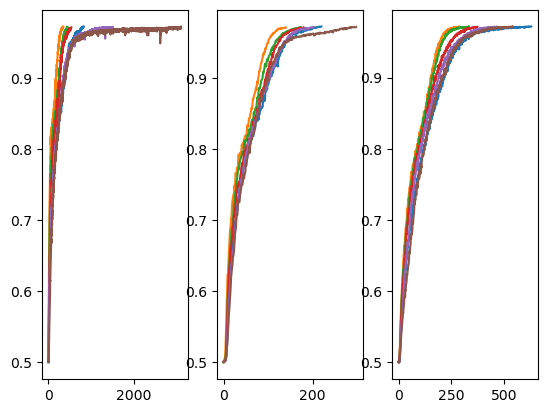

In [164]:
Ws=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    subplot(1,3,k+1)
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        As=[]
        L=[]
        for rep in range(20):
            A=collectorA["{0} {1} {2}".format(kind,cond,rep)]
            As.append(A)
            L.append(len(A))
        for rep in range(20):
            while len(As[rep])<max(L):
                As[rep].append(As[rep][-1])
        W=numpy.array(As)
        plot(W.mean(0))
        Ws["{0} {1}".format(kind,cond)]=W

{0: [[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 4, 5, 6, 7, 8, 9, 11], [0, 1, 4, 5, 7, 8, 9, 11], [0, 1, 4, 5, 7, 9, 11], [0, 1, 4, 5, 7, 9], [0, 1, 4, 7, 9], [0, 1, 4, 9], [0, 4, 9], [0, 4], [0], []], 1: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11], [0, 1, 3, 4, 5, 6, 7, 8, 10, 11], [0, 1, 3, 5, 6, 7, 8, 10, 11], [1, 3, 5, 6, 7, 8, 10, 11], [1, 3, 5, 7, 8, 10, 11], [1, 3, 5, 8, 10, 11], [1, 3, 5, 8, 10], [3, 5, 8, 10], [3, 8, 10], [3, 10], [3], []], 2: [[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 4, 5, 6, 7, 8, 10, 11], [0, 1, 2, 5, 6, 7, 8, 10, 11], [1, 2, 5, 6, 7, 8, 10, 11], [1, 2, 5, 6, 7, 8, 11], [1, 2, 5, 6, 8, 11], [1, 2, 5, 6, 11], [2, 5, 6, 11], [2, 6, 11], [2, 11], [2], []]}


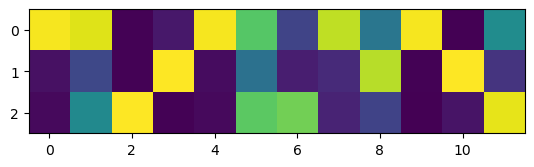

In [240]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::dsLength].transpose()
    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

print(S)
imshow(removalIntoMatrix(S,12,H))

(1100, 12) -2.8278728 3.4340115
-0.03275557805420526 0.019322413229183155
(1100, 12) -2.5029445 2.9091215
-0.06918527870453861 0.047887542485892
(1100, 12) -2.6564622 3.2250357
-0.059770847207118116 0.050922975699118744
(1100, 12) -2.5889578 2.956399
-0.07024786185014698 0.1912286269190755
(1100, 12) -2.9888353 3.1007571
-0.06786353736990769 0.18349892606187002
(1100, 12) -2.8181126 3.4183834
-0.1227421569476137 0.266937015555075
(1100, 12) -2.7940946 3.400782
-0.07547369681590066 0.2235252059942825
(1100, 12) -2.7589202 3.434735
-0.14815245187592208 0.18030005474976196
(1100, 12) -2.708971 3.2062478
-0.08171654331381628 0.22896487171441304
(1100, 12) -2.8708475 3.3671234
-0.0371749327253994 0.16335651779584381
(1100, 12) -2.7366939 2.9452581
-0.07879861151236778 0.23845823229660112


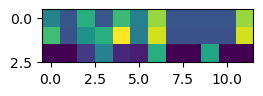

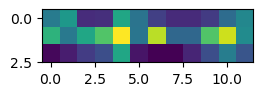

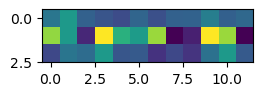

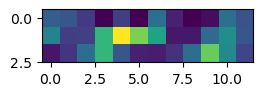

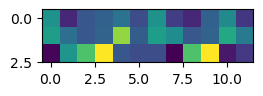

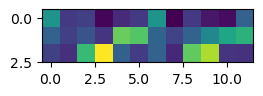

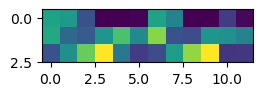

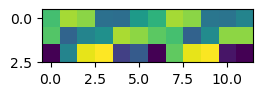

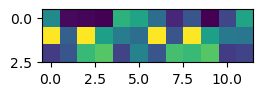

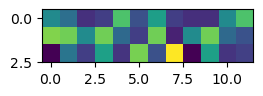

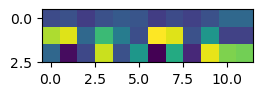

In [235]:
model=NetLSTM()
model=torch.load("models/model_LSTM_1_0.model")
for i in range(11):
    s,t=generateTrainData(100,0.05,[6])
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=11)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    imshow(M)
    print(M.min(),M.max())

(55, 12) -0.9854612 0.99918514
(55, 12) -0.99250007 0.9736963
(55, 12) -2.7535105 1.4978772


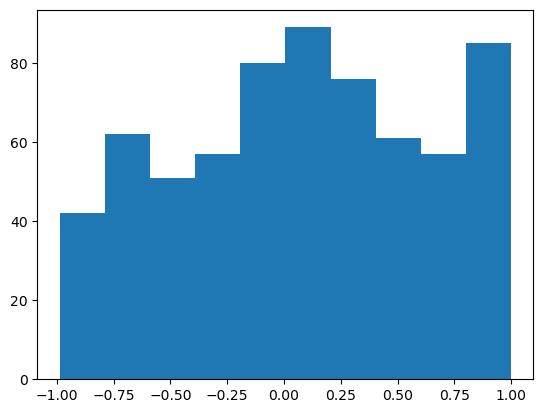

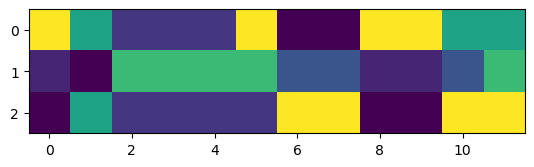

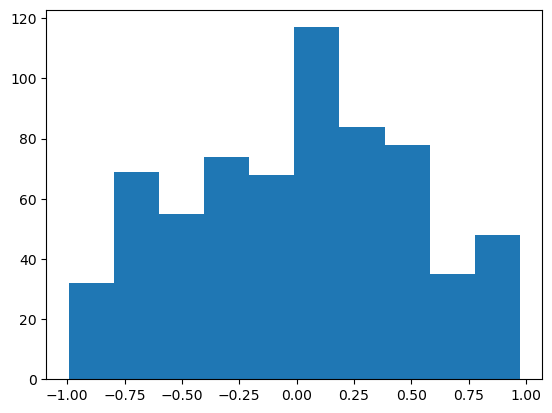

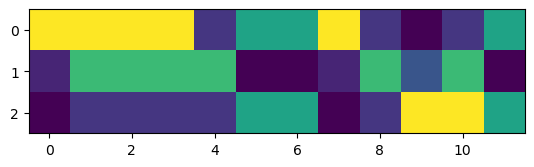

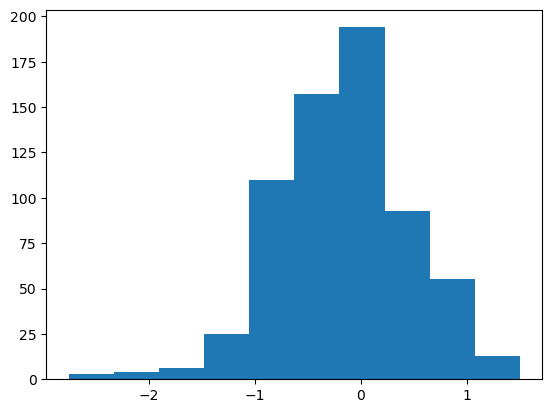

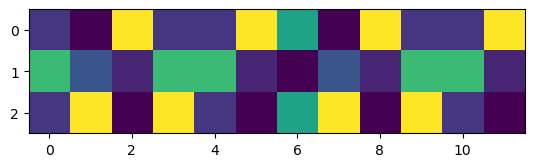

In [236]:
modelRNN=NetRNN()
modelRNN=torch.load("models/model_RNN_0_0.model")
modelGRU=NetGRU()
modelGRU=torch.load("models/model_GRU_0_0.model")
modelLSTM=NetLSTM()
modelLSTM=torch.load("models/model_LSTM_0_0.model")
s,t=generateTrainData(5,0.05,[6])
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),whichTS=6,dsLength=11)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelGRU,12,s,t.transpose(),whichTS=6,dsLength=11)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelLSTM,12,s,t.transpose(),whichTS=6,dsLength=11)
figure()
imshow(removalIntoMatrix(S,12,H))


In [255]:
!mkdir dataSHMLongDelay

In [256]:
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12)
            model=torch.load("modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            for i in [11,12,13,14,15]:#[6,7,8,9,10]:
                s,t=generateTrainData(500,0.05,[6],baseTPS=[0,1,2,3,4,5,6,7,8,9])
                S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=16)
                M=removalIntoMatrix(S,12,H)
                pickle.dump([S,H,M],open("dataSHMLongDelay/SHM_{0}_{1}_{2}_{3}.p".format(kind,cond,rep,i),"wb"))
            print(kind,cond,rep)

RNN 0 0
RNN 0 1
RNN 0 2
RNN 0 3
RNN 0 4
RNN 0 5
RNN 0 6
RNN 0 7
RNN 0 8
RNN 0 9
RNN 0 10
RNN 0 11
RNN 0 12
RNN 0 13
RNN 0 14
RNN 0 15
RNN 0 16
RNN 0 17
RNN 0 18
RNN 0 19
RNN 1 0
RNN 1 1
RNN 1 2
RNN 1 3
RNN 1 4
RNN 1 5
RNN 1 6
RNN 1 7
RNN 1 8
RNN 1 9
RNN 1 10
RNN 1 11
RNN 1 12
RNN 1 13
RNN 1 14
RNN 1 15
RNN 1 16
RNN 1 17
RNN 1 18
RNN 1 19
RNN 2 0
RNN 2 1
RNN 2 2
RNN 2 3
RNN 2 4
RNN 2 5
RNN 2 6
RNN 2 7
RNN 2 8
RNN 2 9
RNN 2 10
RNN 2 11
RNN 2 12
RNN 2 13
RNN 2 14
RNN 2 15
RNN 2 16
RNN 2 17
RNN 2 18
RNN 2 19
RNN 3 0
RNN 3 1
RNN 3 2
RNN 3 3
RNN 3 4
RNN 3 5
RNN 3 6
RNN 3 7
RNN 3 8
RNN 3 9
RNN 3 10
RNN 3 11
RNN 3 12
RNN 3 13
RNN 3 14
RNN 3 15
RNN 3 16
RNN 3 17
RNN 3 18
RNN 3 19
RNN 4 0
RNN 4 1
RNN 4 2
RNN 4 3
RNN 4 4
RNN 4 5
RNN 4 6
RNN 4 7
RNN 4 8
RNN 4 9
RNN 4 10
RNN 4 11
RNN 4 12
RNN 4 13
RNN 4 14
RNN 4 15
RNN 4 16
RNN 4 17
RNN 4 18
RNN 4 19
RNN 5 0
RNN 5 1
RNN 5 2
RNN 5 3
RNN 5 4
RNN 5 5
RNN 5 6
RNN 5 7
RNN 5 8
RNN 5 9
RNN 5 10
RNN 5 11
RNN 5 12
RNN 5 13
RNN 5 14
RNN 5 15
RNN 5 16
RNN 5 1

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_43478/2400196357.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(5,5,where)


RNN 0 0.9516029488281782 0.004792530853047293
RNN 1 0.9284073990623324 0.0067390366651246545
RNN 2 0.890813085120539 0.025674154651741325
RNN 3 0.7593068521143598 0.08363036594489802
RNN 4 0.8005023172029225 0.052468479427850746
RNN 5 0.8169278762462087 0.02448410468058463
GRU 0 0.9747427630354978 0.0005342712250639303
GRU 1 0.9761880263221253 0.0005977515574958842
GRU 2 0.9629665464510955 0.00267167754630476
GRU 3 0.971323049667978 0.0008856455680614542
GRU 4 0.9724445448837188 0.0005178226552031162
GRU 5 0.9570094296797699 0.0029963915398671295
LSTM 0 0.9814689243229163 0.00036131545291058254
LSTM 1 0.9745596042767193 0.0009350929203982354
LSTM 2 0.9583049351371592 0.0024911375515489116
LSTM 3 0.9648714640342597 0.0016098451549375647
LSTM 4 0.9611694097892484 0.002978951774275256
LSTM 5 0.9172480683081015 0.011833158563257984


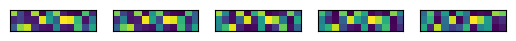

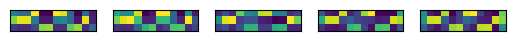

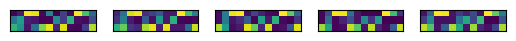

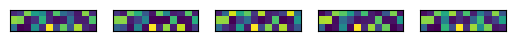

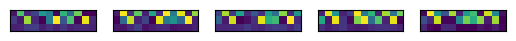

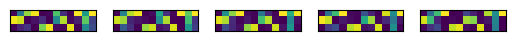

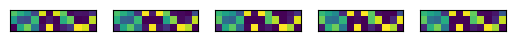

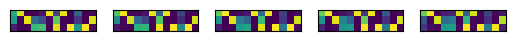

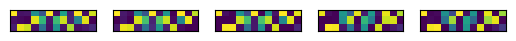

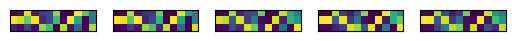

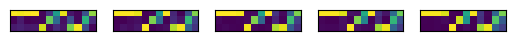

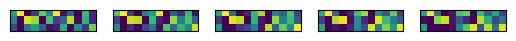

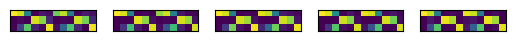

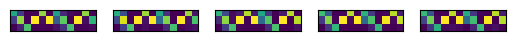

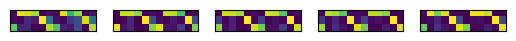

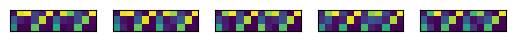

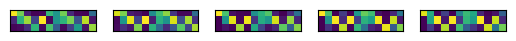

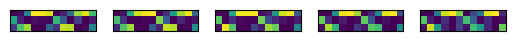

In [3]:
collectorSHM=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        C=[]
        figure()
        title(kind)
        where=1
        for rep in range(20):
            Ms=[]
            for i in [11,12,13,14,15]:#range(5):#[6,7,8,9,10]:
                S,H,M=pickle.load(open("dataSHMLongDelay/SHM_{0}_{1}_{2}_{3}.p".format(kind,cond,rep,i),"rb"))
                collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]=M
                Ms.append(M.flatten())
                if rep==0:
                    subplot(5,5,where)
                    where+=1
                    imshow(M)
                    xticks([])
                    yticks([])
            for i in [11,12,13,14,15]:#[6,7,8,9,10]:
                for j in [11,12,13,14,15]:#[6,7,8,9,10]:
                    if i>j:
                        cc=corrcoef(Ms[i-11],Ms[j-11])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
#pickle.dump(collectorSHM,open("collectorSHMlong.p","wb"))

In [7]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

RNN 0 0.9571393152376994 0.0002340417058685821
RNN 1 0.9291962164195762 0.001213289668106254
RNN 2 0.9343695860230864 0.0009046713242155446
RNN 3 0.9787033891326167 4.264453058398154e-05
RNN 4 0.8855940333768804 0.002367049561879901
RNN 5 0.8632378670743682 0.002669960702763245
GRU 0 0.9711573657908533 0.00014346717320597798
GRU 1 0.9659626490328124 0.00018242884642294822
GRU 2 0.974953312453577 0.00016284014036448545
GRU 3 0.97194648330355 0.00034940245972458556
GRU 4 0.9862407933405439 6.0464676750229636e-05
GRU 5 0.9830951108067175 0.00011349777851661466
LSTM 0 0.9677830001191123 0.0005124588535589707
LSTM 1 0.9863300081835117 5.914325216257332e-05
LSTM 2 0.9877969585626096 6.019104053826519e-05
LSTM 3 0.9921325111076599 2.4986474726209136e-05
LSTM 4 0.94928141172312 0.0010310501081276285
LSTM 5 0.9136016501117667 0.00172172326027355


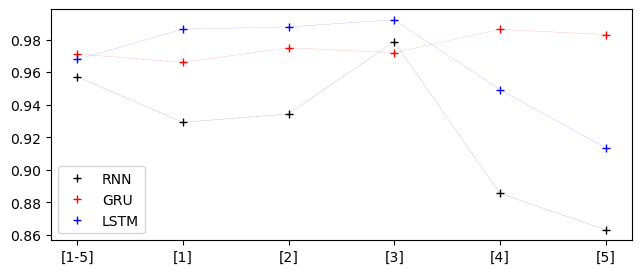

In [14]:
figure(figsize=[7.5,3])
cols=['k','r','b']
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    MC=[]
    MS=[]
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        for rep in range(20):
            Ms=[]
            C=[]
            for i in [11,12,13,14,15]:#range(5):#[6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                Ms.append(M.flatten())
                #if rep==0:
                #    subplot(5,5,where)
                #    where+=1
                #    imshow(M)
                #    xticks([])
                #    yticks([])
            for i in [11,12,13,14,15]:#[6,7,8,9,10]:
                for j in [11,12,13,14,15]:#[6,7,8,9,10]:
                    if i>j:
                        cc=corrcoef(Ms[i-11],Ms[j-11])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
        MC.append(mean(C))
        MS.append(mean_confidence_interval(C))
    plot(range(6),MC,'+',color=cols[k],label=kind)
    plot(range(6),MC,':',linewidth=0.2,color=cols[k])
    xticks(range(6),['[1-5]','[1]','[2]','[3]','[4]','[5]'])
legend()

RNN [1, 2, 3, 4, 5] 0.9034722222222222
RNN [1] 0.9027777777777778
RNN [2] 0.8830176767676767
RNN [3] 0.7922348484848485
RNN [4] 0.7745580808080809
RNN [5] 0.7753156565656566
GRU [1, 2, 3, 4, 5] 0.9474116161616162
GRU [1] 0.9482323232323232
GRU [2] 0.937310606060606
GRU [3] 0.944949494949495
GRU [4] 0.9498106060606061
GRU [5] 0.9227272727272727
LSTM [1, 2, 3, 4, 5] 0.9563762626262626
LSTM [1] 0.9554292929292929
LSTM [2] 0.9299873737373737
LSTM [3] 0.9362373737373737
LSTM [4] 0.9256313131313132
LSTM [5] 0.9026515151515151


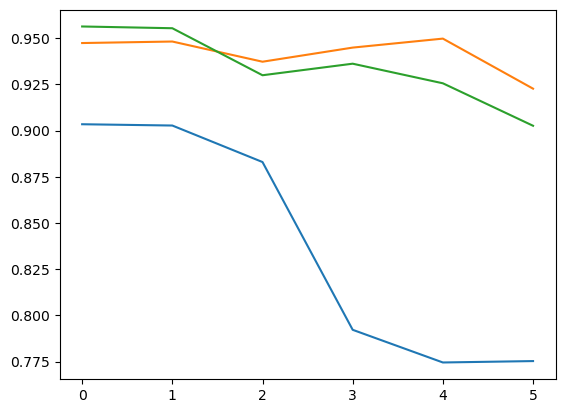

In [23]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    Rs=[]
    RsS=[]
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        R=[]
        for rep in range(20):
            Ns=[]
            for i in [11,12,13,14,15]:#range(5):#[6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                Ns.append(numpy.array(N))
            same=0
            diff=0
            for r in range(3):
                for n in range(4):
                    for i in range(12):
                        for j in range(12):
                            if i<j:
                                a= Ns[n][r][i]  == Ns[n][r][j]
                                b= Ns[n+1][r][i]== Ns[n+1][r][j]
                                if a==b:
                                    same+=1
                                else:
                                    diff+=1
            ratio=same/(same+diff)
            R.append(ratio)
        print(kind,td,mean(R))
        Rs.append(mean(R))
    plot(Rs)

In [85]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))

rowDist=dict()
colDist=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        row=[]
        col=[]
        for rep in range(20):
            for i in [11,12,13,14,15]:#range(5):#[6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                N=numpy.array(N)
                row.append(N.sum(0))
                col.append(N.sum(1))
        row=numpy.array(row)
        col=numpy.array(col)
        H0,H1=histogram(row.flatten(),[0,1,2,3,4])
        rowDist["{0} {1}".format(kind,cond)]=H0/H0.sum()
        H0,H1=histogram(col.flatten(),[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
        colDist["{0} {1}".format(kind,cond)]=H0/H0.sum()
        print(kind,td,"row:",row.flatten().mean(),"col",col.flatten().mean())

RNN [1, 2, 3, 4, 5] row: 1.3416666666666666 col 5.366666666666666
RNN [1] row: 1.415 col 5.66
RNN [2] row: 1.3516666666666666 col 5.406666666666666
RNN [3] row: 1.3141666666666667 col 5.256666666666667
RNN [4] row: 1.3083333333333333 col 5.233333333333333
RNN [5] row: 1.4125 col 5.65
GRU [1, 2, 3, 4, 5] row: 1.3425 col 5.37
GRU [1] row: 1.4075 col 5.63
GRU [2] row: 1.4083333333333334 col 5.633333333333334
GRU [3] row: 1.3741666666666668 col 5.496666666666667
GRU [4] row: 1.4866666666666666 col 5.946666666666666
GRU [5] row: 1.3608333333333333 col 5.443333333333333
LSTM [1, 2, 3, 4, 5] row: 1.2033333333333334 col 4.8133333333333335
LSTM [1] row: 1.26 col 5.04
LSTM [2] row: 1.2233333333333334 col 4.8933333333333335
LSTM [3] row: 1.3133333333333332 col 5.253333333333333
LSTM [4] row: 1.3266666666666667 col 5.306666666666667
LSTM [5] row: 1.3175 col 5.27


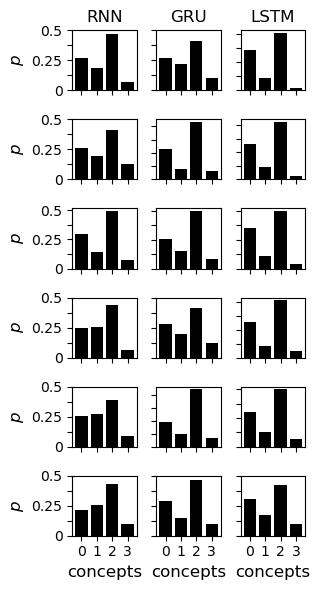

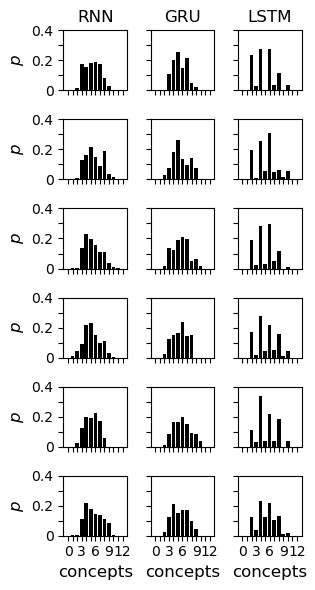

In [84]:
figure(figsize=[3.25,6])
where=1
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    for k,kind in enumerate(["RNN","GRU","LSTM"]):
        subplot(6,3,where)
        where+=1
        H=rowDist["{0} {1}".format(kind,cond)]
        bar([0,1,2,3],H,color='k')
        if cond==0:
            title(kind,fontsize=12)
        if k==0:
            yticks([0,0.125,0.25,0.375,0.5],["0","","0.25","","0.5"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.125,0.25,0.375,0.5],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3],["","","",""],fontsize=10)
tight_layout()

figure(figsize=[3.25,6])
where=1
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    for k,kind in enumerate(["RNN","GRU","LSTM"]):
        subplot(6,3,where)
        where+=1
        if cond==0:
            title(kind,fontsize=12)
        H=colDist["{0} {1}".format(kind,cond)]
        bar([0,1,2,3,4,5,6,7,8,9,10,11,12],H,color='k')
        if k==0:
            yticks([0,0.1,0.2,0.3,0.4],["0","","0.2","","0.4"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.1,0.2,0.3,0.4],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,"","","3","","",6,"","","9","","",12],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[""]*13,fontsize=10)
            
tight_layout()

(8, 5, 4) (8, 3) (3, 8, 2) (40, 3)


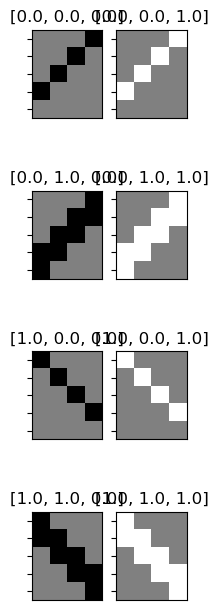

In [263]:
#make dataset
startCondition=[
    [ 0.0, 0.0, 0.0, 0.0,-1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0,-1.0,-1.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    [ 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [-1.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
]
X=[]
Y=[]
worldS=[[],[],[]]
worldConcept=[]
figure(figsize=[2,8])
for d in range(2):
    for s in range(2):
        for b in range(2):
            sequence=[]
            condInt=d*4+s*2+b
            currentCondition=startCondition[condInt]
            for steps in range(5):
                row=[0.0,0.0,0.0,0.0]
                for r in range(4):
                    row[r]=currentCondition[r+1]
                if d==0:
                    currentCondition.pop(0)
                    currentCondition.append(0.0)
                else:
                    currentCondition.pop()
                    currentCondition.insert(0,0.0)
                #print(d,s,b,steps,row)
                sequence.append(row)
                worldConcept.append([d,s,b])
            subplot(4,2,condInt+1)
            X.append(copy.deepcopy(sequence))
            answer=[float(d),float(s),float(b)]
            Y.append(answer)
            imshow(sequence,cmap="gray",vmin=-1.0,vmax=1.0)
            #ylim(-0.5,7.5)
            xticks([],[])
            yticks(range(5),[""]*5)
            title(answer)
            subAd=[0.0,0.0]
            subAd[d]=1.0
            subAs=[0.0,0.0]
            subAs[s]=1.0
            subAb=[0.0,0.0]
            subAb[b]=1.0
            worldS[0].append(subAd)
            worldS[1].append(subAs)
            worldS[2].append(subAb)
    #tight_layout()
trainX=numpy.array(X)
trainY=numpy.array(Y)
worldS=numpy.array(worldS)
worldConcept=numpy.array(worldConcept)
print(trainX.shape,trainY.shape,worldS.shape,worldConcept.shape)
#direction,size,brightness

In [447]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3],conceptNoise=[0.0,0.0,0.0]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            doit=True
            for k in range(3):
                if wc[n][k]==1:
                    if numpy.random.random()<conceptNoise[k]:
                        doit=False
            if doit:
                dr=numpy.random.choice(delayRange)
                M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
                nX.append(M+numpy.random.normal(0.0,noise,(M.shape)))
                nY.append(Y[n])
    nX=numpy.array(nX)
    nY=numpy.array(nY)
    if randomize:
        m=nX.shape[0]
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
    return nX,nY
nX,nY=makeNoisyDataset(trainX,trainY,8,0.2,delayRange=[3,4],conceptNoise=[0.0,0.0,0.0])
#h=hist(nX.flatten(),linspace(-1.5,1.5,101))
print(nX.shape,nY.shape)

(64,) (64, 3)


/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/2945697412.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


In [278]:
collectorA=dict()
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    if True:
        for rep in range(20):
            for kind in ["RNN","GRU","LSTM"]:
                if kind=="RNN":
                    model=NetRNN(hidden_dim=12,inp=4)
                if kind=="GRU":
                    model=NetGRU(hidden_dim=12,inp=4)
                if kind=="LSTM":
                    model=NetLSTM(hidden_dim=12,inp=4)

                optimizer = optim.Adam(model.parameters())
                error = nn.MSELoss()

                acc=0.0
                W=[]
                A=[]
                while acc<0.97:
                    model.resetHidden()
                    s,t=makeNoisyDataset(trainX,trainY,8,0.2,delayRange=td)
                    divs=[]
                    for i in range(s.shape[0]): #use 64 when training for single delayRange
                        optimizer.zero_grad()
                        output = model(torch.Tensor(s[i].reshape(1,s[i].shape[0],4))) #shape greater than 8
                        loss = error(output, torch.Tensor(t[i]))
                        loss.backward()
                        optimizer.step()
                        div=output.detach().numpy().reshape(t[i].shape)-t[i]
                        divs.append(1.0-abs(div).mean())
                    W.append(loss.item())
                    acc=mean(divs)
                    A.append(acc)
                    if acc<0.97 and len(A)>2000:
                        if kind=="RNN":
                            model=NetRNN(hidden_dim=12,inp=4)
                        if kind=="GRU":
                            model=NetGRU(hidden_dim=12,inp=4)
                        if kind=="LSTM":
                            model=NetLSTM(hidden_dim=12,inp=4)
                        optimizer = optim.Adam(model.parameters())
                        error = nn.MSELoss()
                        acc=0.0
                        W=[]
                        A=[]
                        print('repeat')
                collectorA["{0} {1} {2}".format(kind,cond,rep)]=A
                torch.save(model,"modelsBlockTask/model_{0}_{1}_{2}.model".format(kind,cond,rep))
                print("{0} {1} {2}".format(kind,cond,rep),len(A))

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/1320451999.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


RNN 0 0 563
GRU 0 0 152
LSTM 0 0 379
RNN 0 1 844
GRU 0 1 136
LSTM 0 1 304
RNN 0 2 512
GRU 0 2 154
LSTM 0 2 245
RNN 0 3 575
GRU 0 3 137
LSTM 0 3 422
RNN 0 4 411
GRU 0 4 158
LSTM 0 4 247
RNN 0 5 494
GRU 0 5 147
LSTM 0 5 571
RNN 0 6 330
GRU 0 6 113
LSTM 0 6 418
RNN 0 7 643
GRU 0 7 174
LSTM 0 7 380
RNN 0 8 403
GRU 0 8 189
LSTM 0 8 300
RNN 0 9 1074
GRU 0 9 130
LSTM 0 9 315
RNN 0 10 643
GRU 0 10 143
LSTM 0 10 465
RNN 0 11 412
GRU 0 11 127
LSTM 0 11 323
RNN 0 12 430
GRU 0 12 133
LSTM 0 12 496
RNN 0 13 627
GRU 0 13 174
LSTM 0 13 389
RNN 0 14 1357
GRU 0 14 215
LSTM 0 14 336
RNN 0 15 640
GRU 0 15 156
LSTM 0 15 293
repeat
RNN 0 16 546
GRU 0 16 133
LSTM 0 16 316
RNN 0 17 367
GRU 0 17 136
LSTM 0 17 265
RNN 0 18 520
GRU 0 18 131
LSTM 0 18 454
RNN 0 19 321
GRU 0 19 122
LSTM 0 19 278
RNN 1 0 193
GRU 1 0 98
LSTM 1 0 246
RNN 1 1 328
GRU 1 1 120
LSTM 1 1 194
RNN 1 2 236
GRU 1 2 95
LSTM 1 2 185
RNN 1 3 192
GRU 1 3 105
LSTM 1 3 207
RNN 1 4 177
GRU 1 4 115
LSTM 1 4 189
RNN 1 5 187
GRU 1 5 104
LSTM 1 5 221
R

In [279]:
pickle.dump(collectorA,open("collectorABlockTask.p","bw"))

In [282]:
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12,inp=4)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12,inp=4)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12,inp=4)
            model=torch.load("modelsBlockTask/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            for i in [6,7,8,9,10]:#[6,7,8,9,10]:
                s,t=makeNoisyDataset(trainX,trainY,8,0.2,delayRange=[6])
                S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=11)
                M=removalIntoMatrix(S,12,H)
                pickle.dump([S,H,M],open("modelsBlockTask/SHM_{0}_{1}_{2}_{3}.p".format(kind,cond,rep,i),"wb"))
            print(kind,cond,rep)

RNN 0 0
RNN 0 1
RNN 0 2
RNN 0 3
RNN 0 4
RNN 0 5
RNN 0 6
RNN 0 7
RNN 0 8
RNN 0 9
RNN 0 10
RNN 0 11
RNN 0 12
RNN 0 13
RNN 0 14
RNN 0 15
RNN 0 16
RNN 0 17
RNN 0 18
RNN 0 19
RNN 1 0
RNN 1 1
RNN 1 2
RNN 1 3
RNN 1 4
RNN 1 5
RNN 1 6
RNN 1 7
RNN 1 8
RNN 1 9
RNN 1 10
RNN 1 11
RNN 1 12
RNN 1 13
RNN 1 14
RNN 1 15
RNN 1 16
RNN 1 17
RNN 1 18
RNN 1 19
RNN 2 0
RNN 2 1
RNN 2 2
RNN 2 3
RNN 2 4
RNN 2 5
RNN 2 6
RNN 2 7
RNN 2 8
RNN 2 9
RNN 2 10
RNN 2 11
RNN 2 12
RNN 2 13
RNN 2 14
RNN 2 15
RNN 2 16
RNN 2 17
RNN 2 18
RNN 2 19
RNN 3 0
RNN 3 1
RNN 3 2
RNN 3 3
RNN 3 4
RNN 3 5
RNN 3 6
RNN 3 7
RNN 3 8
RNN 3 9
RNN 3 10
RNN 3 11
RNN 3 12
RNN 3 13
RNN 3 14
RNN 3 15
RNN 3 16
RNN 3 17
RNN 3 18
RNN 3 19
RNN 4 0
RNN 4 1
RNN 4 2
RNN 4 3
RNN 4 4
RNN 4 5
RNN 4 6
RNN 4 7
RNN 4 8
RNN 4 9
RNN 4 10
RNN 4 11
RNN 4 12
RNN 4 13
RNN 4 14
RNN 4 15
RNN 4 16
RNN 4 17
RNN 4 18
RNN 4 19
RNN 5 0
RNN 5 1
RNN 5 2
RNN 5 3
RNN 5 4
RNN 5 5
RNN 5 6
RNN 5 7
RNN 5 8
RNN 5 9
RNN 5 10
RNN 5 11
RNN 5 12
RNN 5 13
RNN 5 14
RNN 5 15
RNN 5 16
RNN 5 1

RNN 0 0.8072710784997426 0.017893872946898263
RNN 1 0.36556979441897136 0.10296609915190313
RNN 2 0.33273506997611196 0.09388092219623274
RNN 3 0.3694813587783355 0.1004500209384031
RNN 4 0.3178960878371595 0.08690539751328412
RNN 5 0.4011121747773765 0.10012194797420795
GRU 0 0.9562458948003076 0.0020297056893934093
GRU 1 0.867708922142364 0.006956365000880974
GRU 2 0.8471655135649272 0.010438509036381853
GRU 3 0.932432579552419 0.004645106201611873
GRU 4 0.9143178994034794 0.007895143287739676
GRU 5 0.8906091371473278 0.009297454176881284
LSTM 0 0.9386960276268308 0.0023597678622778256
LSTM 1 0.8152840784918038 0.022692660032450157
LSTM 2 0.8829668269350778 0.008166225205598147
LSTM 3 0.881423941453418 0.013676590178074014
LSTM 4 0.8518615821699355 0.019889129153741966
LSTM 5 0.8144542764474645 0.03375106973262173


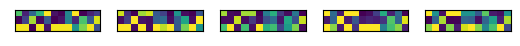

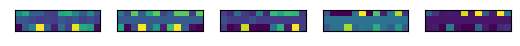

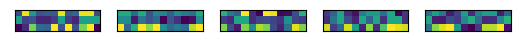

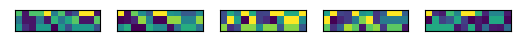

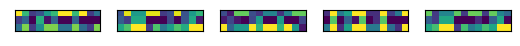

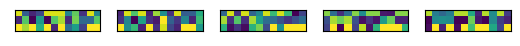

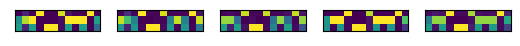

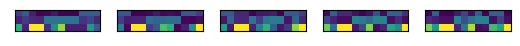

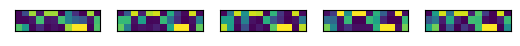

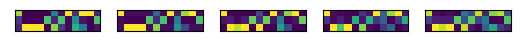

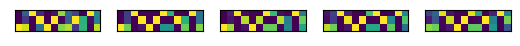

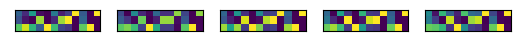

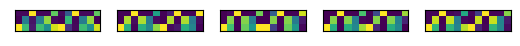

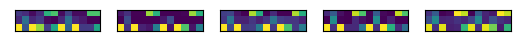

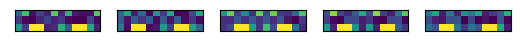

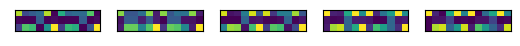

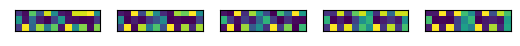

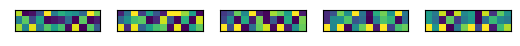

In [405]:
collectorSHM=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        C=[]
        figure()
        title(kind)
        where=1
        for rep in range(20):
            Ms=[]
            for i in [6,7,8,9,10]:
                S,H,M=pickle.load(open("modelsBlockTask/SHM_{0}_{1}_{2}_{3}.p".format(kind,cond,rep,i),"rb"))
                collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]=M
                Ms.append(M.flatten())
                if rep==0:
                    subplot(5,5,where)
                    where+=1
                    imshow(M)
                    xticks([])
                    yticks([])
            for i in range(5):
                for j in range(5):#[6,7,8,9,10]:
                    if i>j:
                        cc=corrcoef(Ms[i],Ms[j])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
pickle.dump(collectorSHM,open("collectorSHMblock.p","wb"))

RNN 0 0.8709163884414703 0.0027376398173125137
RNN 1 0.018956028500972555 0.05814331420887361
RNN 2 0.5615002783840282 0.0192148851194237
RNN 3 0.5460209740586294 0.05001202163756924
RNN 4 -0.00043991374349378433 0.019534051954311533
RNN 5 0.44301890383844483 0.03761903428837937
GRU 0 0.9588710679004757 0.0007729619113104778
GRU 1 0.8609137256650782 0.002230216533193437
GRU 2 0.9253771774183631 0.0007696553829987768
GRU 3 0.91215417170842 0.0012454301304866944
GRU 4 0.941546111891713 0.0032605528349396095
GRU 5 0.89340777852425 0.003891081523643212
LSTM 0 0.958383454156461 0.0002728182620155352
LSTM 1 0.9560781700177148 0.0003550950908889104
LSTM 2 0.8549851621364767 0.007958603883649981
LSTM 3 0.9752482949044533 9.887691273236805e-05
LSTM 4 0.9720713585786126 0.00011846595524115278
LSTM 5 0.763056979817201 0.01650513999893089


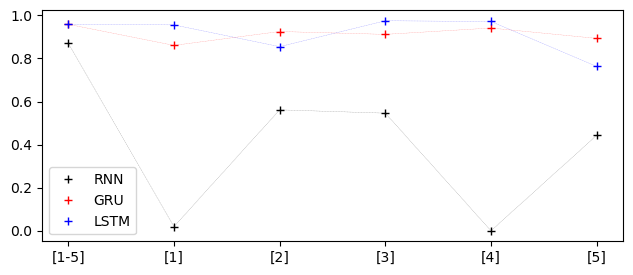

In [26]:
figure(figsize=[7.5,3])
cols=['k','r','b']
collectorSHM=pickle.load(open("collectorSHMblock.p","rb"))
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    MC=[]
    MS=[]
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        for rep in range(20):
            Ms=[]
            C=[]
            for i in [6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                Ms.append(M.flatten())
                #if rep==0:
                #    subplot(5,5,where)
                #    where+=1
                #    imshow(M)
                #    xticks([])
                #    yticks([])
            for i in range(5):#[6,7,8,9,10]:
                for j in range(5):#[6,7,8,9,10]:
                    if i>j:
                        cc=corrcoef(Ms[i],Ms[j])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
        MC.append(mean(C))
        MS.append(mean_confidence_interval(C))
    plot(range(6),MC,'+',color=cols[k],label=kind)
    plot(range(6),MC,':',linewidth=0.2,color=cols[k])
    xticks(range(6),['[1-5]','[1]','[2]','[3]','[4]','[5]'])
legend()

RNN [1, 2, 3, 4, 5] 0.772159090909091
RNN [1] 0.5753787878787879
RNN [2] 0.5617424242424243
RNN [3] 0.5686237373737374
RNN [4] 0.5391414141414141
RNN [5] 0.5963383838383839
GRU [1, 2, 3, 4, 5] 0.9
GRU [1] 0.8079545454545455
GRU [2] 0.8416035353535354
GRU [3] 0.8940025252525252
GRU [4] 0.8706439393939394
GRU [5] 0.8664141414141414
LSTM [1, 2, 3, 4, 5] 0.8868686868686868
LSTM [1] 0.7789772727272727
LSTM [2] 0.8547348484848485
LSTM [3] 0.86489898989899
LSTM [4] 0.835479797979798
LSTM [5] 0.8541666666666666


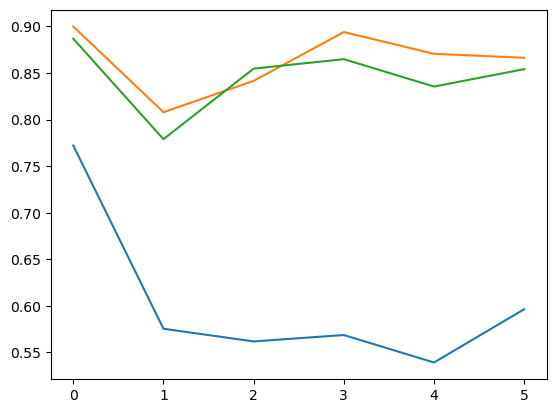

In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

for k,kind in enumerate(["RNN","GRU","LSTM"]):
    Rs=[]
    RsS=[]
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        R=[]
        for rep in range(20):
            Ns=[]
            for i in [6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                Ns.append(numpy.array(N))
            same=0
            diff=0
            for r in range(3):
                for n in range(4):
                    for i in range(12):
                        for j in range(12):
                            if i<j:
                                a= Ns[n][r][i]  == Ns[n][r][j]
                                b= Ns[n+1][r][i]== Ns[n+1][r][j]
                                if a==b:
                                    same+=1
                                else:
                                    diff+=1
            ratio=same/(same+diff)
            R.append(ratio)
        print(kind,td,mean(R))
        Rs.append(mean(R))
    plot(Rs)

In [86]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
collectorSHM=pickle.load(open("collectorSHMblock.p","rb"))

rowDist=dict()
colDist=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        row=[]
        col=[]
        for rep in range(20):
            for i in [6,7,8,9,10]:
                M=collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)]
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                N=numpy.array(N)
                row.append(N.sum(0))
                col.append(N.sum(1))
        row=numpy.array(row)
        col=numpy.array(col)
        H0,H1=histogram(row.flatten(),[0,1,2,3,4])
        rowDist["{0} {1}".format(kind,cond)]=H0/H0.sum()
        H0,H1=histogram(col.flatten(),[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
        colDist["{0} {1}".format(kind,cond)]=H0/H0.sum()
        print(kind,td,"row:",row.flatten().mean(),"col",col.flatten().mean())

RNN [1, 2, 3, 4, 5] row: 1.4108333333333334 col 5.6433333333333335
RNN [1] row: 1.3625 col 5.45
RNN [2] row: 1.3458333333333334 col 5.383333333333334
RNN [3] row: 1.4075 col 5.63
RNN [4] row: 1.3033333333333332 col 5.213333333333333
RNN [5] row: 1.3933333333333333 col 5.573333333333333
GRU [1, 2, 3, 4, 5] row: 1.3875 col 5.55
GRU [1] row: 1.3225 col 5.29
GRU [2] row: 1.4016666666666666 col 5.6066666666666665
GRU [3] row: 1.3566666666666667 col 5.426666666666667
GRU [4] row: 1.39 col 5.56
GRU [5] row: 1.3816666666666666 col 5.526666666666666
LSTM [1, 2, 3, 4, 5] row: 1.3733333333333333 col 5.493333333333333
LSTM [1] row: 1.3383333333333334 col 5.3533333333333335
LSTM [2] row: 1.3558333333333332 col 5.423333333333333
LSTM [3] row: 1.4083333333333334 col 5.633333333333334
LSTM [4] row: 1.3758333333333332 col 5.503333333333333
LSTM [5] row: 1.3775 col 5.51


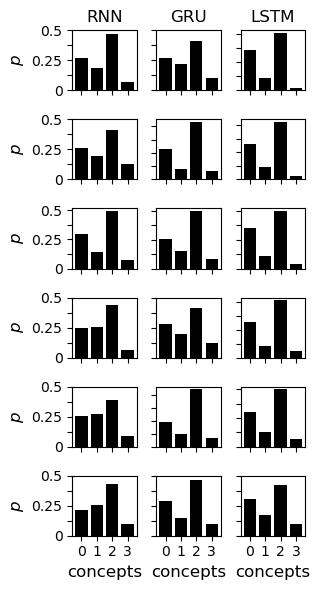

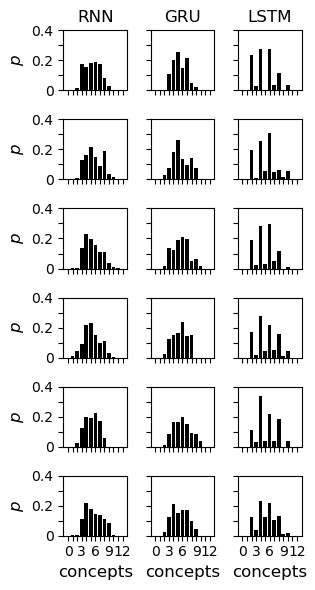

In [83]:
figure(figsize=[3.25,6])
where=1
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    for k,kind in enumerate(["RNN","GRU","LSTM"]):
        subplot(6,3,where)
        where+=1
        H=rowDist["{0} {1}".format(kind,cond)]
        bar([0,1,2,3],H,color='k')
        if cond==0:
            title(kind,fontsize=12)
        if k==0:
            yticks([0,0.125,0.25,0.375,0.5],["0","","0.25","","0.5"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.125,0.25,0.375,0.5],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3],["","","",""],fontsize=10)
tight_layout()

figure(figsize=[3.25,6])
where=1
for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
    for k,kind in enumerate(["RNN","GRU","LSTM"]):
        subplot(6,3,where)
        where+=1
        if cond==0:
            title(kind,fontsize=12)
        H=colDist["{0} {1}".format(kind,cond)]
        bar([0,1,2,3,4,5,6,7,8,9,10,11,12],H,color='k')
        if k==0:
            yticks([0,0.1,0.2,0.3,0.4],["0","","0.2","","0.4"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.1,0.2,0.3,0.4],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,"","","3","","",6,"","","9","","",12],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[""]*13,fontsize=10)
            
tight_layout()

In [ ]:
# Are the patterns for concepts excluding each other
# and are they moving in LSTM and GRUs less than in RNNs
# Or: Oops, they are moving within RNNs!!!
# -> no plots showing the above!

In [370]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h


0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5


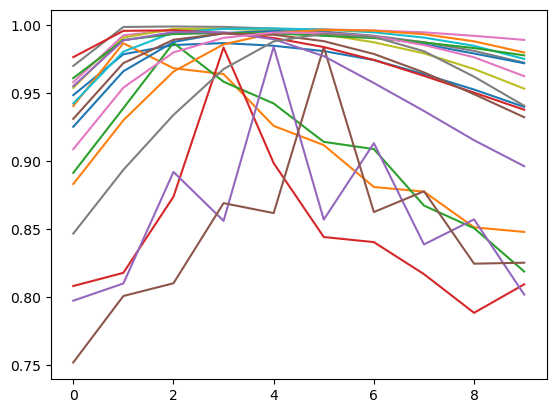

In [358]:
collector=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        A=[]
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12)
            model=torch.load("modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            for oversample in range(10):
                acc=[]
                for i in range(10):
                    s,t=generateTrainData(500,0.05,[i],baseTPS=[0,1,2,3,4,5,6,7,8,9])
                    out=model(torch.Tensor(s))
                    acc.append((1.0*((1.0*(out.detach().numpy()>0.5))==t)).flatten().mean())
                A.append(acc)
        plot(numpy.array(A).mean(0))
        print(k,cond)
        collector["{0} {1}".format(k,cond)]=numpy.array(A)

In [360]:
pickle.dump(collector,open("collectorWlongRange.p","wb"))

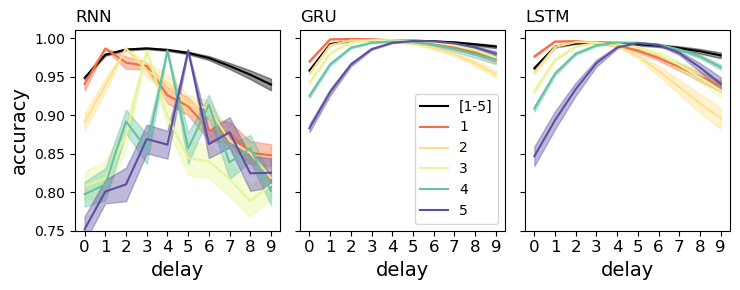

In [390]:
figure(figsize=[7.5,3])
collector=pickle.load(open("collectorWlongRange.p","rb"))
cmap = matplotlib.cm.get_cmap('Spectral')
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    subplot(1,3,k+1)
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        A=collector["{0} {1}".format(k,cond)]
        m=A.mean(0)
        #s=A.std(0)/sqrt(len(A))
        if cond==0:
            col='k'
            L='[1-5]'
        else:
            col=cmap(linspace(0,1,6)[cond])
            L=str(cond)
        s=mean_confidence_interval(A)
        fill_between(range(10),m+s,m-s,alpha=0.4,color=col)
        plot(m,color=col,label=L)
    ylim(0.75,1.01)
    if k==1:
        legend()
    if k!=0:
        yticks([0.75,0.8,0.85,0.9,0.95,1.0],["","","","","",""],fontsize=12)
    else:
        ylabel("accuracy",fontsize=14)
    xticks(range(10),["0","1","2","3","4","5","6","7","8","9"],fontsize=12)
    xlabel("delay",fontsize=14)
    title(kind,fontsize=12,loc="left")
tight_layout()

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5


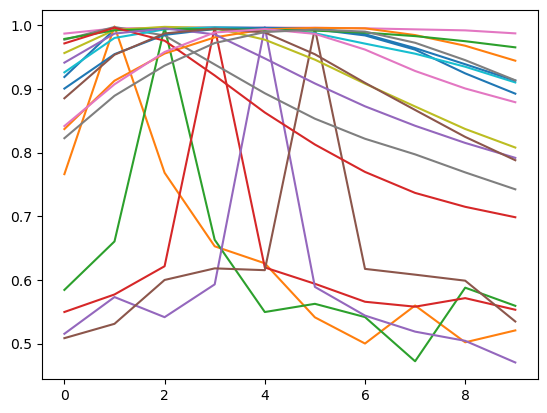

In [392]:
collector=dict()
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        A=[]
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12,inp=4)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12,inp=4)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12,inp=4)
            model=torch.load("modelsBlockTask/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            for oversampling in range(10):
                acc=[]
                for i in range(10):
                    s,t=makeNoisyDataset(trainX,trainY,8,0.2,delayRange=[i])
                    #s,t=generateTrainData(500,0.05,[6],baseTPS=[0,1,2,3,4,5,6,7,8,9])
                    out=model(torch.Tensor(s))
                    acc.append((1.0*((1.0*(out.detach().numpy()>0.5))==t)).flatten().mean())
                A.append(acc)
        plot(numpy.array(A).mean(0))
        print(k,cond)
        collector["{0} {1}".format(k,cond)]=numpy.array(A)

In [393]:
pickle.dump(collector,open("collectorBlock.p","wb"))

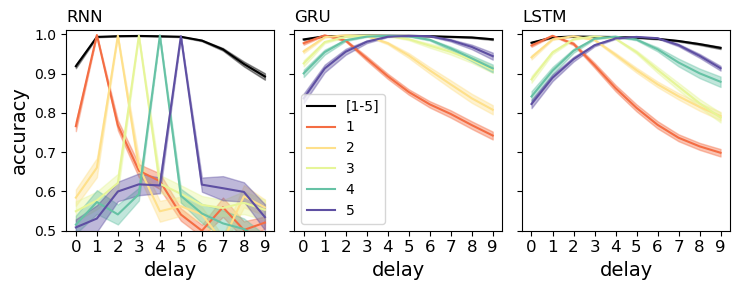

In [404]:
figure(figsize=[7.5,3])
collector=pickle.load(open("collectorBlock.p","rb"))
cmap = matplotlib.cm.get_cmap('Spectral')
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    subplot(1,3,k+1)
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        A=collector["{0} {1}".format(k,cond)]
        m=A.mean(0)
        #s=A.std(0)/sqrt(len(A))
        if cond==0:
            col='k'
            L='[1-5]'
        else:
            col=cmap(linspace(0,1,6)[cond])
            L=str(cond)
        s=mean_confidence_interval(A)
        fill_between(range(10),m+s,m-s,alpha=0.4,color=col)
        plot(m,color=col,label=L)
    ylim(0.5,1.01)
    if k==1:
        legend()
    if k!=0:
        yticks([0.5,0.6,0.7,0.8,0.9,1.0],["","","","","",""],fontsize=12)
    else:
        ylabel("accuracy",fontsize=14)
    xticks(range(10),["0","1","2","3","4","5","6","7","8","9"],fontsize=12)
    xlabel("delay",fontsize=14)
    title(kind,fontsize=12,loc="left")
tight_layout()

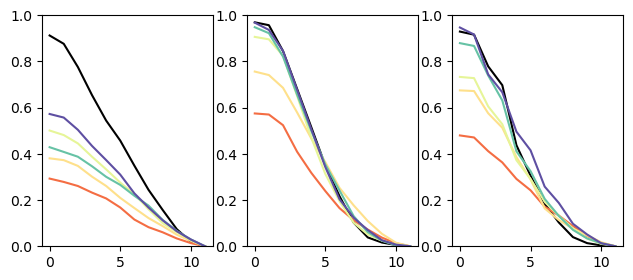

In [432]:
collectorSHM=pickle.load(open("collectorSHMblock.p","rb"))
figure(figsize=[7.5,3])
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    subplot(1,3,k+1)
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        #subplot(1,6,cond+1)
        for i in [6,7,8,9,10]:
            R=[]
            C=[]
            for rep in range(20):
                M=numpy.abs(collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)])
                for j in range(3):
                    R.append(sort(M[j]))
                for j in range(12):
                    C.append(sort(M.transpose()[j]))
        if cond==0:
            col='k'
            L='[1-5]'
        else:
            col=cmap(linspace(0,1,6)[cond])
            L=str(cond)
        plot(flip(numpy.array(R).mean(0)),color=col)
        ylim(0.0,1)

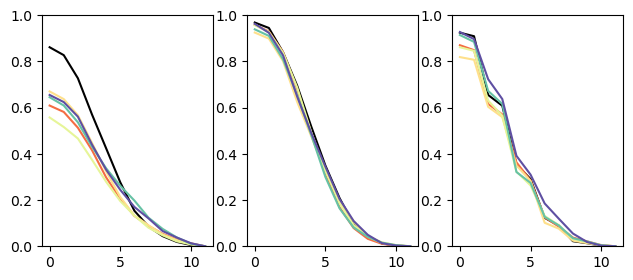

In [433]:
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))
figure(figsize=[7.5,3])
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    subplot(1,3,k+1)
    for cond,td in enumerate([[1,2,3,4,5],[1],[2],[3],[4],[5]]):
        #subplot(1,6,cond+1)
        for i in [11,12,13,14,15]:
            R=[]
            C=[]
            for rep in range(20):
                M=numpy.abs(collectorSHM["{0} {1} {2} {3}".format(k,cond,rep,i)])
                for j in range(3):
                    R.append(sort(M[j]))
                for j in range(12):
                    C.append(sort(M.transpose()[j]))
        if cond==0:
            col='k'
            L='[1-5]'
        else:
            col=cmap(linspace(0,1,6)[cond])
            L=str(cond)
        plot(flip(numpy.array(R).mean(0)),color=col)
        ylim(0,1)

In [463]:
mc=dict()

for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5]]):
        #for i in [11,12,13,14,15]:
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12)
            modelL=torch.load("modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            model.load_state_dict(modelL.state_dict())
            for i,n in enumerate(linspace(0.0,1.0,11)):
                for conc in range(3):
                    cn=[0.0,0.0,0.0]
                    cn[conc]=n
                    s,t=generateTrainData(500,0.05,[6],baseTPS=[0,1,2,3,4,5,6,7,8,9],conceptNoise=cn)
                    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=13,dsLength=16)
                    M=removalIntoMatrix(S,12,H)
                    #subplot(11,3,where)
                    #imshow(M)
                    mc["{0} {1} {2} {3} {4}".format(k,cond,rep,i,conc)]=M
            print(kind,cond,rep)

RNN 0 0
RNN 0 1
RNN 0 2
RNN 0 3
RNN 0 4
RNN 0 5
RNN 0 6
RNN 0 7
RNN 0 8
RNN 0 9
RNN 0 10
RNN 0 11
RNN 0 12
RNN 0 13
RNN 0 14
RNN 0 15
RNN 0 16
RNN 0 17
RNN 0 18
RNN 0 19
GRU 0 0
GRU 0 1
GRU 0 2
GRU 0 3
GRU 0 4
GRU 0 5
GRU 0 6
GRU 0 7
GRU 0 8
GRU 0 9
GRU 0 10
GRU 0 11
GRU 0 12
GRU 0 13
GRU 0 14
GRU 0 15
GRU 0 16
GRU 0 17
GRU 0 18
GRU 0 19
LSTM 0 0
LSTM 0 1
LSTM 0 2
LSTM 0 3
LSTM 0 4
LSTM 0 5
LSTM 0 6
LSTM 0 7
LSTM 0 8
LSTM 0 9
LSTM 0 10
LSTM 0 11
LSTM 0 12
LSTM 0 13
LSTM 0 14
LSTM 0 15
LSTM 0 16
LSTM 0 17
LSTM 0 18
LSTM 0 19


In [464]:
pickle.dump(mc,open("collectorMCLongDelay.p","wb"))

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/43866395.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/43866395.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/43866395.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()


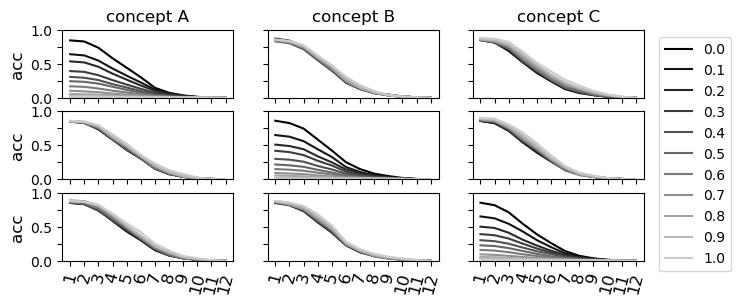

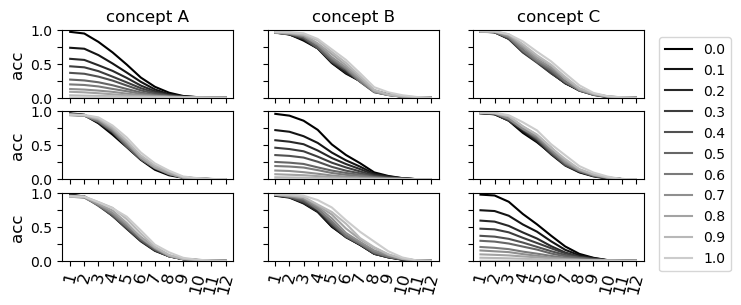

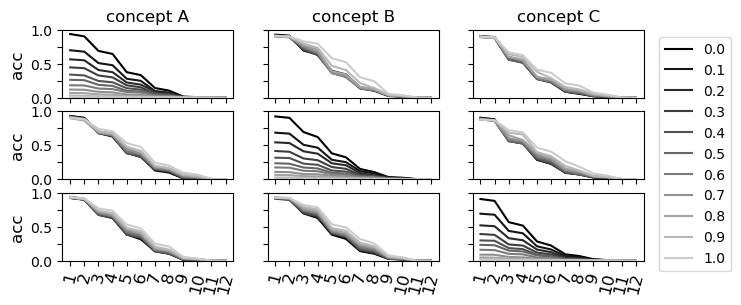

In [504]:
mc=pickle.load(open("collectorMCLongDelay.p","rb"))
cols=matplotlib.cm.get_cmap('autumn')
colsG=matplotlib.cm.get_cmap('gray')
concepts=["concept A","concept B","concept C"]
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    figure(figsize=[7.5,3])
    for conc in range(3):
        for cond in range(3):
            subplot(3,3,cond+(conc*3)+1)
            for i,n in enumerate(linspace(0.0,1.0,11)):
                D=[]
                for rep in range(20):
                    M=numpy.abs(mc["{0} {1} {2} {3} {4}".format(k,0,rep,i,conc)])
                    D.append(flip(sort(list(M[cond]))))
                plot(range(1,13),numpy.array(D).mean(0),color=colsG(n*0.8),label=str(numpy.round(n,1)))
                ylim(0,1)
                if conc==2:
                    xticks(range(1,13),fontsize=12,rotation=75)
                else:
                    xticks(range(1,13),[""]*12)
                if cond==0:
                    yticks([0,0.25,0.5,0.75,1.0],['0.0','','0.5','','1.0'],fontsize=10)
                    ylabel("acc",fontsize=12)
                else:
                    yticks([0,0.25,0.5,0.75,1.0],[""]*5)
                if cond==2 and conc==0:
                    legend(bbox_to_anchor=(1.05, 1))
                if conc==0:
                    title(concepts[cond])
    tight_layout()
    savefig("noising_{0}_longDelay.pdf".format(kind))

In [467]:
mc=dict()
mc=dict()

for k,kind in enumerate(["RNN","GRU","LSTM"]):
    for cond,td in enumerate([[1,2,3,4,5]]):
        #for i in [11,12,13,14,15]:
        for rep in range(20):
            if kind=="RNN":
                model=NetRNN(hidden_dim=12,inp=4)
            if kind=="GRU":
                model=NetGRU(hidden_dim=12,inp=4)
            if kind=="LSTM":
                model=NetLSTM(hidden_dim=12,inp=4)

            modelL=torch.load("modelsBlockTask/model_{0}_{1}_{2}.model".format(kind,cond,rep))
            model.load_state_dict(modelL.state_dict())
            where=1
            for i,n in enumerate(linspace(0.0,1.0,11)):
                for conc in range(3):
                    cn=[0.0,0.0,0.0]
                    cn[conc]=n
                    #s,t=generateTrainData(500,0.05,[6],baseTPS=[0,1,2,3,4,5,6,7,8,9],conceptNoise=cn)
                    s,t=makeNoisyDataset(trainX,trainY,16,0.2,delayRange=[3],conceptNoise=cn)
                    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=3,dsLength=8)
                    M=removalIntoMatrix(S,12,H)
                    mc["{0} {1} {2} {3} {4}".format(k,cond,rep,i,conc)]=M
            print(kind,cond,rep)

RNN 0 0
RNN 0 1
RNN 0 2
RNN 0 3
RNN 0 4
RNN 0 5
RNN 0 6
RNN 0 7
RNN 0 8
RNN 0 9
RNN 0 10
RNN 0 11
RNN 0 12
RNN 0 13
RNN 0 14
RNN 0 15
RNN 0 16
RNN 0 17
RNN 0 18
RNN 0 19
GRU 0 0
GRU 0 1
GRU 0 2
GRU 0 3
GRU 0 4
GRU 0 5
GRU 0 6
GRU 0 7
GRU 0 8
GRU 0 9
GRU 0 10
GRU 0 11
GRU 0 12
GRU 0 13
GRU 0 14
GRU 0 15
GRU 0 16
GRU 0 17
GRU 0 18
GRU 0 19
LSTM 0 0
LSTM 0 1
LSTM 0 2
LSTM 0 3
LSTM 0 4
LSTM 0 5
LSTM 0 6
LSTM 0 7
LSTM 0 8
LSTM 0 9
LSTM 0 10
LSTM 0 11
LSTM 0 12
LSTM 0 13
LSTM 0 14
LSTM 0 15
LSTM 0 16
LSTM 0 17
LSTM 0 18
LSTM 0 19


In [468]:
pickle.dump(mc,open("collectorMCBlocks.p","wb"))

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/2508927951.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/2508927951.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_67942/2508927951.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  tight_layout()


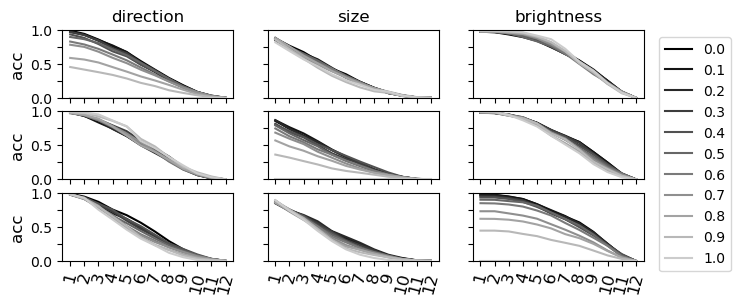

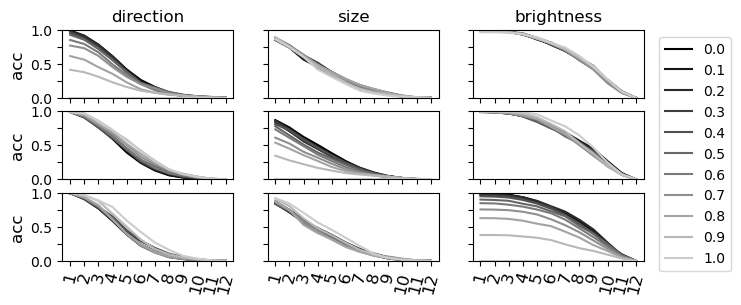

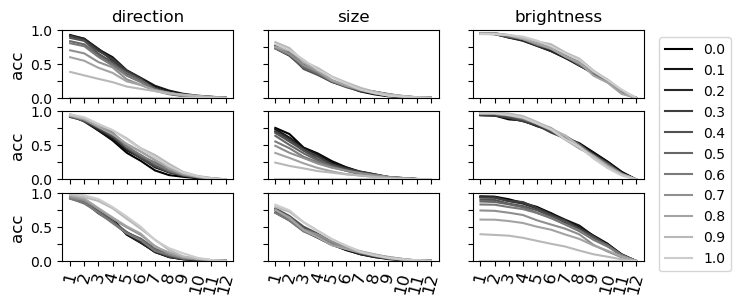

In [506]:
mc=pickle.load(open("collectorMCBlocks.p","rb"))
cols=matplotlib.cm.get_cmap('autumn')
colsG=matplotlib.cm.get_cmap('gray')
#direction,size,brightness
concepts=["direction","size","brightness"]
for k,kind in enumerate(["RNN","GRU","LSTM"]):
    figure(figsize=[7.5,3])
    for conc in range(3):
        for cond in range(3):
            subplot(3,3,cond+(conc*3)+1)
            for i,n in enumerate(linspace(0.0,1.0,11)):
                D=[]
                for rep in range(20):
                    M=numpy.abs(mc["{0} {1} {2} {3} {4}".format(k,0,rep,i,conc)])
                    D.append(flip(sort(list(M[cond]))))
                plot(range(1,13),numpy.array(D).mean(0),color=colsG(n*0.8),label=str(numpy.round(n,1)))
                ylim(0,1)
                if conc==2:
                    xticks(range(1,13),fontsize=12,rotation=75)
                else:
                    xticks(range(1,13),[""]*12)
                if cond==0:
                    yticks([0,0.25,0.5,0.75,1.0],['0.0','','0.5','','1.0'],fontsize=10)
                    ylabel("acc",fontsize=12)
                else:
                    yticks([0,0.25,0.5,0.75,1.0],[""]*5)
                if cond==2 and conc==0:
                    legend(bbox_to_anchor=(1.05, 1))
                if conc==0:
                    title(concepts[cond])
    tight_layout()
    savefig("noising_{0}_Block.pdf".format(kind))

In [507]:
!ls

collectorA.p               dataSHMLongDelay
collectorABlockTask.p      models
collectorALongDelay.p      modelsBlockTask
collectorBlock.p           modelsLongDelay
collectorMCBlocks.p        noising_GRU_Block.pdf
collectorMCLongDelay.p     noising_GRU_longDelay.pdf
collectorSHMblock.p        noising_LSTM_Block.pdf
collectorSHMlong.p         noising_LSTM_longDelay.pdf
collectorWlongRange.p      noising_RNN_Block.pdf
data                       noising_RNN_longDelay.pdf
data.tar.gz                script.ipynb
dataSHM                    tempArbitrary.ipynb


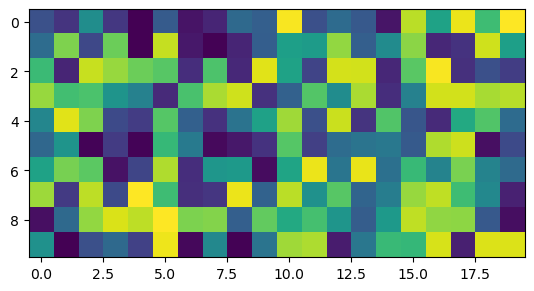

In [3]:
M=numpy.random.random((10,20))
imshow(M)

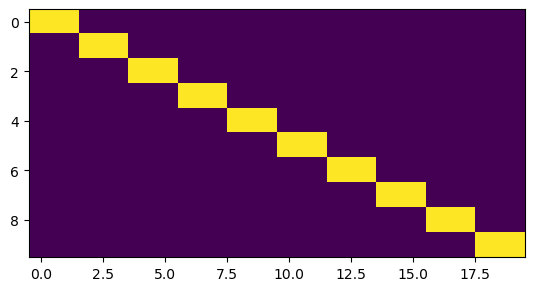

In [7]:
M=numpy.zeros((20,10))
for i in range(10):
    M[i*2][i]=1
    M[i*2+1][i]=1
imshow(M.transpose())

In [191]:
from sklearn.decomposition import PCA
#modelRNN=NetRNN()
#modelRNN=torch.load("models/model_RNN_1_0.model")
#modelRNN.inp=3
#modelGRU=NetGRU()
#modelGRU=torch.load("models/model_GRU_1_0.model")
#modelGRU.inp=3
modelLSTM=NetLSTM()
modelLSTM=torch.load("models/model_LSTM_1_0.model")
modelLSTM.inp=3
s,t=generateTrainData(1000,0.0,[1],baseTPS=[0,1,2,3,4,5,6,7,8,10])
#for i in range(10):
#    out=modelRNN(torch.Tensor(numpy.array(s[i]).reshape(1,len(s[i]),3)))
#    print((out.detach().numpy()>0.5)*1.0,t[i])

#out,hidden=modelRNN.step(torch.Tensor(numpy.array(s)))
#out,hidden=modelGRU.step(torch.Tensor(numpy.array(s)))
out,hidden=modelLSTM.step(torch.Tensor(numpy.array(s)))


In [192]:
pca = PCA(n_components=2)
pca.fit(hidden[10::11])
h=pca.transform(hidden)
print(h.shape,t.shape)

(11000, 2) (1000, 3)


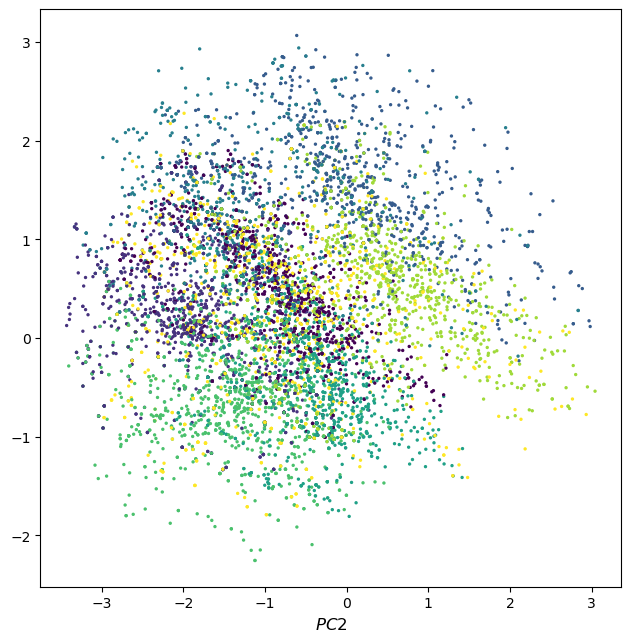

In [193]:
cmap = plt.get_cmap('viridis')
colors=[]
for r in t:
    i=r[0]+(r[1]*2)+(r[2]*4)
    colors.append(cmap(numpy.linspace(0,1,8)[i]))
colors=numpy.array(colors)
colors=numpy.repeat(colors,11,axis=0)
figure(figsize=[7.5,7.5])
scatter(h.transpose()[0],h.transpose()[1],c=colors,s=2.0)
xlabel(r"$PC1$",fontsize=12)
xlabel(r"$PC2$",fontsize=12)
print()

In [173]:
colors

array([0.212395, 0.212395, 0.212395, ..., 1.      , 1.      , 1.      ])